# Classifier comparison on EFRI movement decoding task
We compare the performance of MORF against several other classifiers on raw stereo-EEG (sEEG) data. Patients in the EFRI cohort were tasked with using a manipulandum to maneuver a cursor from a central starting point to a target zone located either up, down, left, or right of center.

## Experimental Setup
The raw sEEG data is a multivariate time series of dimension $N \times C \times T$, where $N$ is the number of trials the task was performed, $C$ is the number of sEEG implantations, and $T$ is the number of time steps. Each patient typically performed around $N=75$ to $N=100$ trials of the experiment successfully and had $C=70$ to $C=100$ channel recordings. The time window in consideration begins -0.2 s before the recorded instance the patient leaves the central starting point until 0.5 s after they have left the central starting point. The sampling frequency was downsampled to 500 Hz, yielding $T = 350$. The labels are integer-encoded directions $\{0,1,2,3\}$ corresponding to down, right, up, and left, respectively.

We analyze the performance of several classifiers against MORF in this multi-class classification problem, primarily evaluating based on the macro-averaged one vs. rest area under the receiver operating curve (OvR AUROC). We show the results over 5-fold stratified cross validation.

by Chester Huynh and Adam Li, *March 2021*

In [6]:
import json
import os
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from mne_bids import BIDSPath
from ptitprince import RainCloud
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

plt.rcParams.update({
    "font.family": "sans-serif", 
    "font.size": 22,
    "figure.titlesize": 22,
})
sns.set_theme()

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Directionality decoding plots

In [39]:
import json
cohort = [
    "efri07",
    "efri13",
    "efri14",
    "efri18",
    "efri20",
]
bids_root = Path("/Users/ChesterHuynh/OneDrive - Johns Hopkins/efri/")
bids_root = Path('/Users/adam2392/OneDrive - Johns Hopkins/efri/')
                 
derivatives_path = bids_root / "derivatives/workstation_output/mtmorf/decode_directionality/"

figures_path = Path('/Users/adam2392/Dropbox/morf-study/derivatives/figures/')

cohort_clf_scores = defaultdict(dict)

# Create mapping from saved filename and figure name
clf_names_for_figure = {
    "MT-MORF": "MORF", 
    "SPORF": "SPORF",
    "RF": "RF", 
    "kNN": "kNN",
    "XGB": "XGB", 
    "MLP": "MLP", 
    "ConvNet": "ConvNet"
}
for subject in cohort:
    for clf_fname, clf_figure_name in clf_names_for_figure.items():
        with open(
            derivatives_path / f"{subject}/tmin=-0.2_tmax=0.5/time_domain/{subject}_{clf_fname}_results.json", "r"
        ) as f:
            cohort_clf_scores[subject][clf_figure_name] = json.load(f)

In [23]:
# df.loc[df.groupby("Subject")[""].idxmin()]
metric = 'roc_auc_ovr'
df = []
for subject, clf_scores in cohort_clf_scores.items():
    for clf_name, scores in clf_scores.items():
        df.append([subject, clf_name, scores[f"test_{metric}"]])
df = pd.DataFrame(df, columns=["Subject", "Classifier", metric])
df = pd.DataFrame({"Subject": np.repeat(df["Subject"].values, df[metric].str.len()),
                        "Classifier": np.repeat(df["Classifier"].values, df[metric].str.len()),
                        metric: np.concatenate(df[metric].values)})
print(df.shape)
display(df.head())

(175, 3)


,Subject,Classifier,roc_auc_ovr
0,efri07,MORF,0.745597
1,efri07,MORF,0.897727
2,efri07,MORF,0.758005
3,efri07,MORF,0.692866
4,efri07,MORF,0.774621


In [24]:
group_cols = ["Classifier", 'Subject']

# create a new DataFrame with a MultiIndex consisting of the group_cols
# and a column for the mean of each column in metric_cols
aggs = df.groupby(group_cols)[metric].median()
# remove the metric_cols from df because we are going to replace them
# with the means in aggs
df.drop(metric, axis=1, inplace=True)
# dedupe to leave only one row with each combination of group_cols
# in df
df.drop_duplicates(subset=group_cols, keep='last', inplace=True)
# add the mean columns from aggs into df
df = df.merge(right=aggs, right_index=True, left_on=group_cols, how='right')

print(df.shape)
display(df.head())

(35, 3)


,Subject,Classifier,roc_auc_ovr
34,efri07,ConvNet,0.500000
69,efri13,ConvNet,0.518700
104,efri14,ConvNet,0.513972
139,efri18,ConvNet,0.543981
174,efri20,ConvNet,0.537908


In [25]:
# Constants for plotting
palette = {
    "MORF":"#e41a1c",
    "SPORF":"#4daf4a",
    "MLP":"#984ea3",
    "SVM":"#a65628", 
    "Log. Reg": "#999999", 
    "XGB":"#cc99ff",
    "ConvNet":"#377eb8",
    "RF":"#ff7f00", 
    "kNN": "#ffff33", 
    "Lin. SVM":"#f781bf"
}
label_names = {0: "Down", 1: "Right", 2: "Up", 3: "Left"}

In [40]:
def plot_directionality_comparison(cohort_clf_scores, metric="roc_auc_ovr", ax=None):
    if ax is None:    
        width = 8
        aspect_ratio = 3/4  # 4:3 aspect ratio
        fig, ax = plt.subplots(figsize=(width, width*aspect_ratio), dpi=300, facecolor='w')

    if metric not in ["roc_auc_ovr", "accuracy", "cohen_kappa_score"]:
        raise ValueError("metric must be one of roc_auc_ovr, accuracy or cohen_kappa_score")

    df = []
    for subject, clf_scores in cohort_clf_scores.items():
        for clf_name, scores in clf_scores.items():
            df.append([subject, clf_name, scores[f"test_{metric}"]])
    df = pd.DataFrame(df, columns=["Subject", "Classifier", metric])
    df = pd.DataFrame({"Subject": np.repeat(df["Subject"].values, df[metric].str.len()),
                            "Classifier": np.repeat(df["Classifier"].values, df[metric].str.len()),
                            metric: np.concatenate(df[metric].values)})
    order = df['Classifier'].unique()
    
    # group by subject statistics
    group_cols = ["Classifier", 'Subject']

    # create a new DataFrame with a MultiIndex consisting of the group_cols
    # and a column for the mean of each column in metric_cols
    aggs = df.groupby(group_cols)[metric].median()
    # remove the metric_cols from df because we are going to replace them
    # with the means in aggs
    df.drop(metric, axis=1, inplace=True)
    # dedupe to leave only one row with each combination of group_cols
    # in df
    df.drop_duplicates(subset=group_cols, keep='last', inplace=True)
    # add the mean columns from aggs into df
    df = df.merge(right=aggs, right_index=True, left_on=group_cols, how='right')

    sns.stripplot(x="Classifier", y=metric, data=df, 
                  order=order, hue='Subject',
                  ax=ax, 
#                   palette=palette
                 )
    
    # Set labels and titles
    ylabel = {
        "roc_auc_ovr": "ROC AUC One vs. Rest",
        "accuracy": "Accuracy",
        "cohen_kappa_score": "Cohen Kappa Score"
    }
    xticklabels = ax.get_xticklabels()
    ax.set_xticklabels(xticklabels, rotation=45, ha="right")
    ax.set_xlabel("Classifier")
    ax.set_ylabel(f"Cross-Validated {ylabel[metric]}")
    ax.set_title(f"Directionality Decoding Performance on Raw sEEG Recordings")
    legendlabel = {
        "roc_auc_ovr": "ROC AUC One vs. Rest (MORF)",
        "accuracy": "Accuracy (MORF)",
        "cohen_kappa_score": "Cohen Kappa Score (MORF)",
    }
#     line = ax.axhline(
#         np.median(df[df["Classifier"] == "MORF"][metric]), 
#         label=f"Median {legendlabel[metric]}", ls="--", lw=2, c='r', alpha=0.7
#     )

    median_width = 0.4
    for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
        sample_name = text.get_text()  # "X" or "Y"

        # calculate the median value for all replicates of either X or Y
        median_val = df[df["Classifier"] == sample_name][metric].median()

        # plot horizontal lines across the column, centered on the tick
        ax.plot(
            [tick - median_width / 2, tick + median_width / 2],
            [median_val, median_val],
            lw=4,
            color="k",
        )

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    # ax.tick_params(axis='x', which='minor', bottom=False)
#     ax.legend([line],[line.get_label()], frameon=False)
    return ax

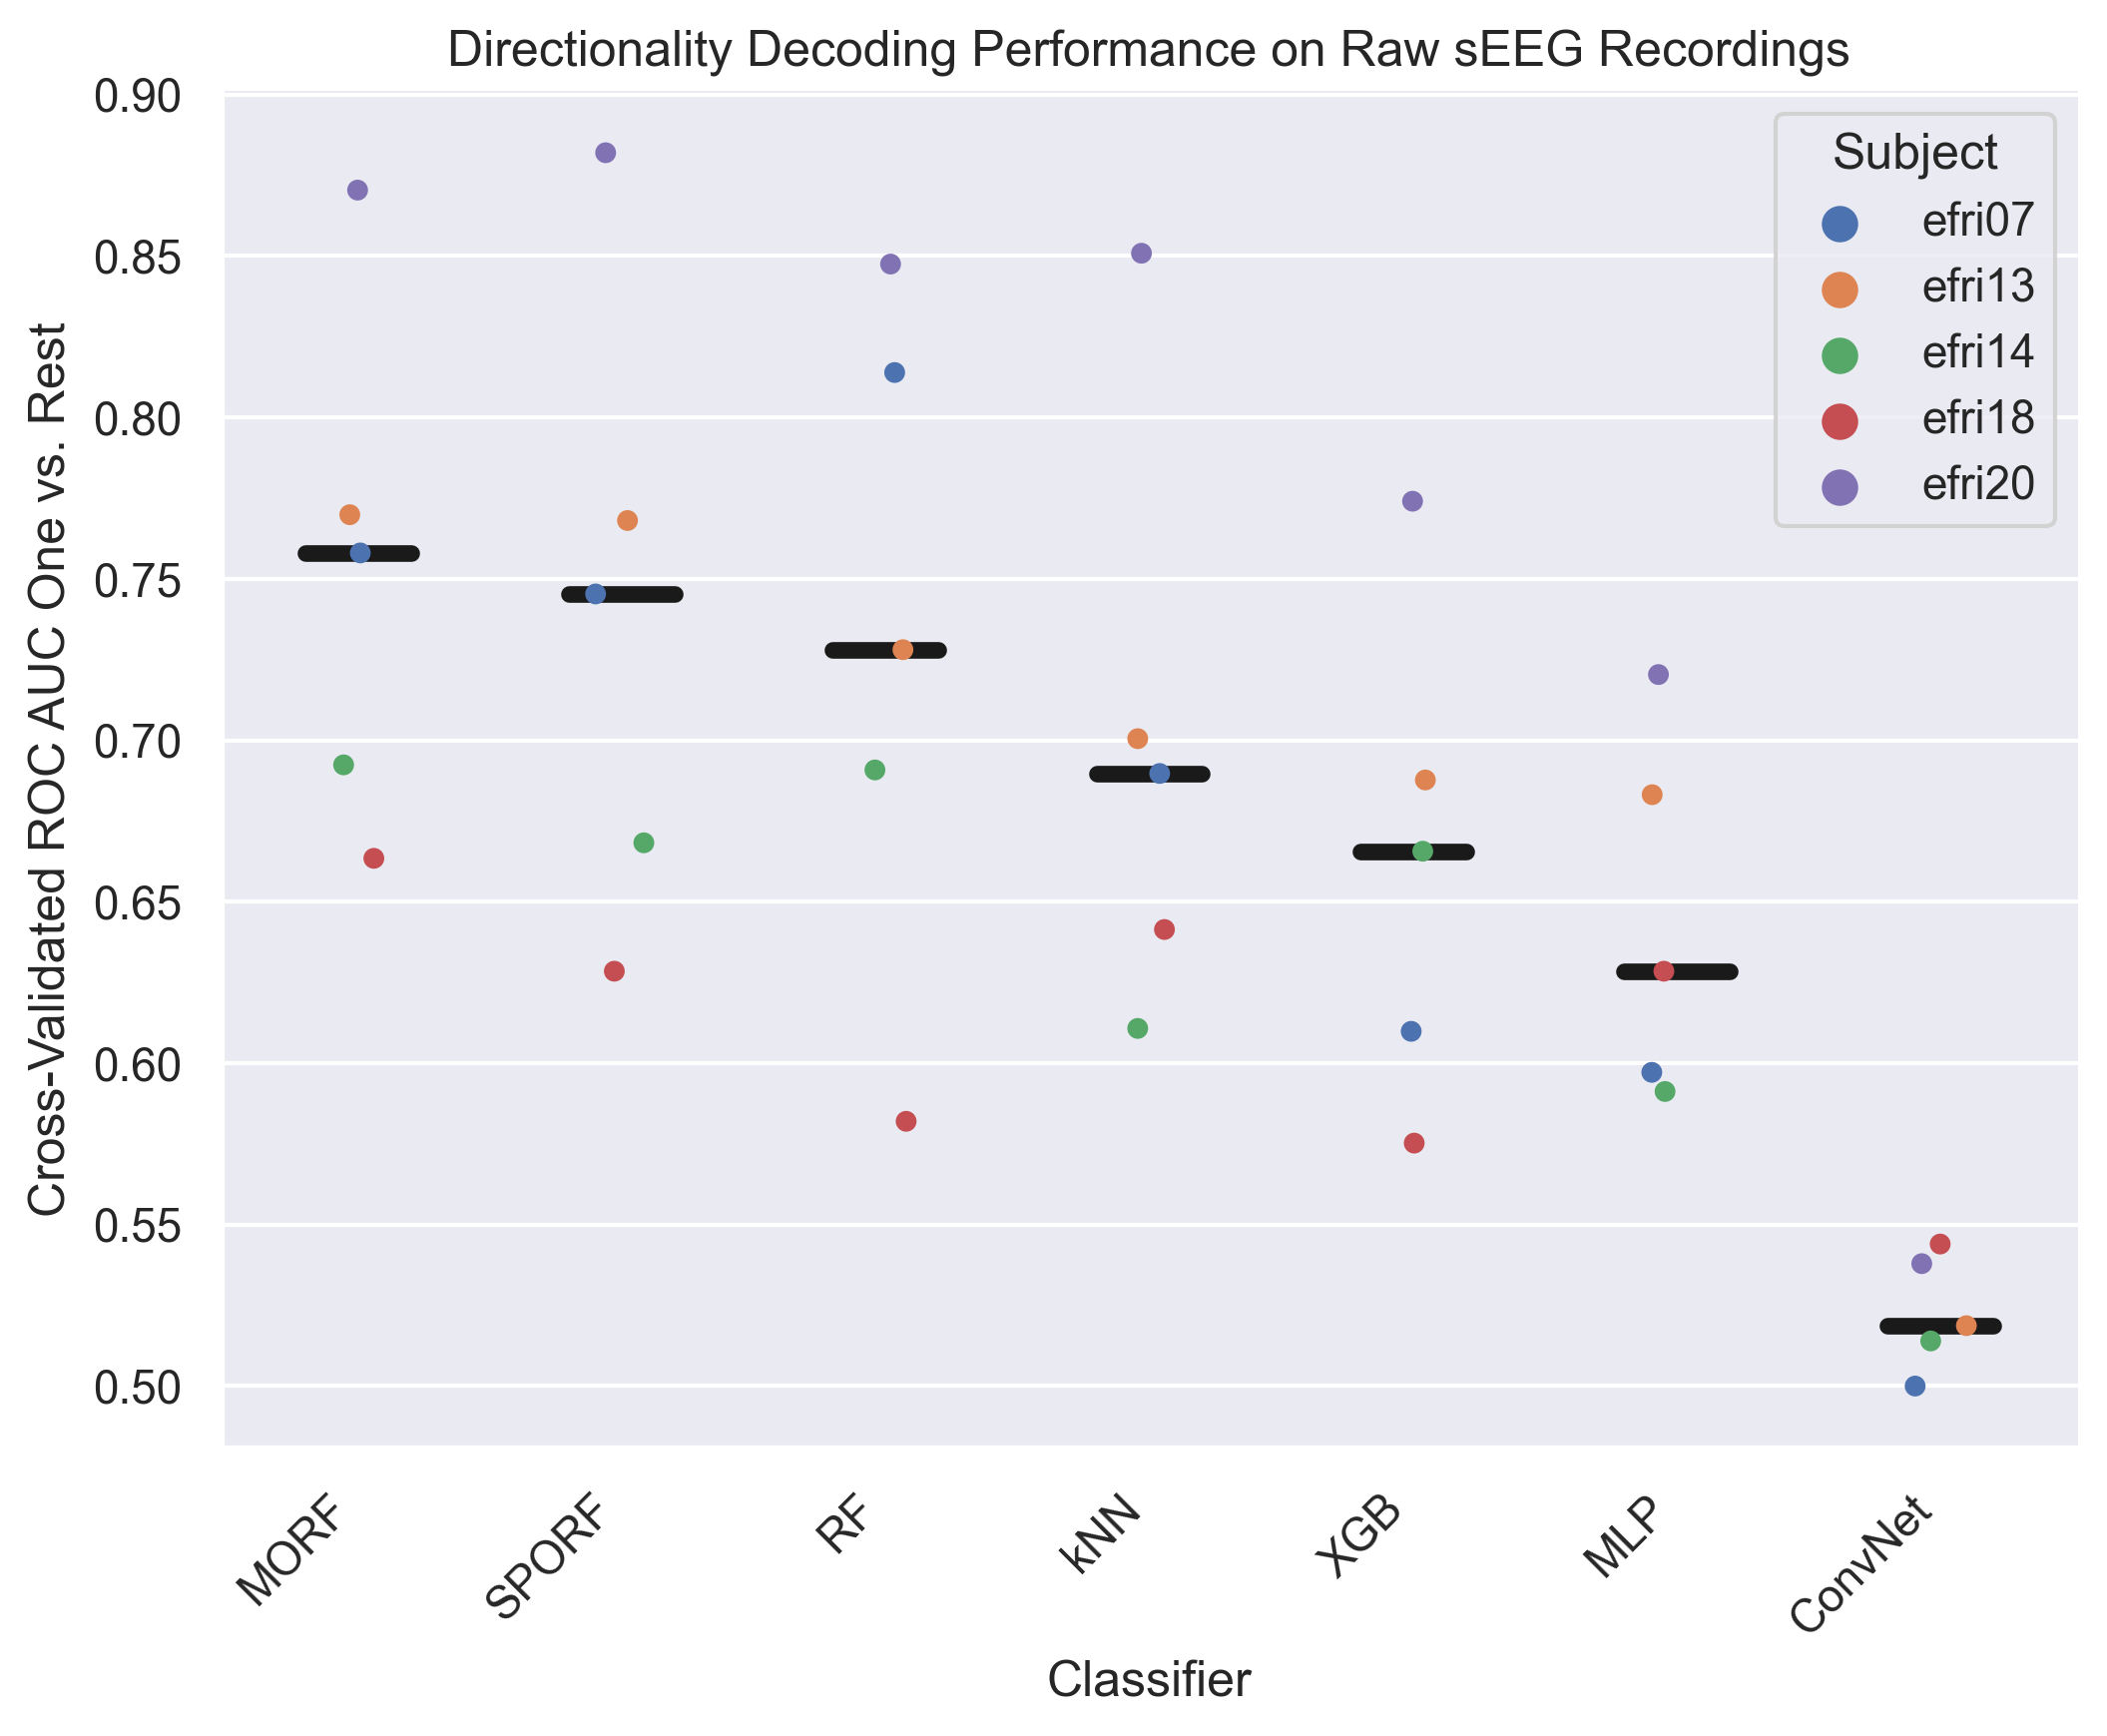

In [41]:
plot_directionality_comparison(cohort_clf_scores, "roc_auc_ovr")
plt.savefig(figures_path / "efri_directionality_decoding_auroc.png");

In [42]:
def _compute_multiclass_auroc(y_true, y_proba, n_classes):
    fprs = []
    tprs = []
    roc_auc = []

    for i in range(n_classes):
        mean_fpr = np.linspace(0, 1, 100)

        fpr, tpr, _ = roc_curve(
            label_binarize(y_true, classes=np.arange(n_classes))[:, i],
            y_proba[:, i],
        )

        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0

        fprs.append(mean_fpr)
        tprs.append(interp_tpr)
        roc_auc.append(auc(fprs[i], tprs[i]))

    return fprs, tprs, roc_auc

In [43]:
def plot_multiclass_roc_comparison(cohort_clf_scores, show_chance=True, axs=None):
    if not axs:
        width = 16
        aspect_ratio = 3/4  # 4:3 aspect ratio
        fig, axs = plt.subplots(2, 2, dpi=300, figsize=(width, width*aspect_ratio), facecolor='w', sharex=True, sharey=True)
        axs = axs.flatten()

    pooled_ytest = np.array([])
    clf_pred_proba = {}
    for subject_idx, (subject, clf_scores) in enumerate(cohort_clf_scores.items()):
        if subject_idx == 0:
            pooled_ytest = clf_scores["MORF"]["y_test"]
        else:
            new_ytest = clf_scores["MORF"]["y_test"]
            pooled_ytest = [np.hstack([cur, new]) for cur, new in zip(pooled_ytest, new_ytest)]
        
        for clf_name, scores in clf_scores.items():
            if subject_idx == 0:
                clf_pred_proba[clf_name] = scores["test_predict_proba"]
            else:
                cur_proba = clf_pred_proba[clf_name]
                new_proba = scores["test_predict_proba"]
                clf_pred_proba[clf_name] = [np.vstack([cur, new]) for cur, new in zip(cur_proba, new_proba)]

    clf_fprs = {}
    clf_tprs = {}
    clf_aucs = {}
    for clf_name, y_pred_probas in clf_pred_proba.items():
        clf_fprs[clf_name] = []
        clf_tprs[clf_name] = []
        clf_aucs[clf_name] = []

        # Compute ROC metrics for each fold
        for i, (y_pred_proba, y_test) in enumerate(zip(y_pred_probas, pooled_ytest)):
            y_pred_proba = np.array(y_pred_proba)

            # Compute ROC metrics for each class
            fpr, tpr, roc_auc = _compute_multiclass_auroc(y_test, y_pred_proba, 4)

            clf_fprs[clf_name].append(fpr)
            clf_tprs[clf_name].append(tpr)
            clf_aucs[clf_name].append(roc_auc)

        # n_folds x n_classes x 100
        clf_fprs[clf_name] = np.array(clf_fprs[clf_name])
        clf_tprs[clf_name] = np.array(clf_tprs[clf_name])
        clf_aucs[clf_name] = np.array(clf_aucs[clf_name])

    for i, ax in enumerate(axs):
        for clf_name in clf_fprs:
            fprs = clf_fprs[clf_name]
            tprs = clf_tprs[clf_name]
            aucs = clf_aucs[clf_name]

            mean_fprs = np.mean(fprs, axis=0)
            mean_tprs = np.mean(tprs, axis=0)
            mean_tprs[:, -1] = 1.0

            mean_fpr = mean_fprs[i]
            mean_tpr = mean_tprs[i]
            mean_auc = auc(mean_fpr, mean_tpr)
            std_auc = np.std(aucs, axis=0)[i]

            ax.plot(
                mean_fpr,
                mean_tpr,
                label=r"{clf_name} Mean ROC (AUC = {mean_auc:.3f} $\pm$ {std_auc:.3f})".format(
                    clf_name=clf_name,
                    mean_auc=mean_auc,
                    std_auc=std_auc,
                ),
                ls="-",
                lw=2,
                c=palette[clf_name]
            )
            ax.set_title(label_names[i])

        if show_chance:
            ax.plot(
                [0, 1], [0, 1], linestyle="--", lw=3, color="r", label="Chance", alpha=0.8
            )

        xlabel = "1-Specificity\n(Predicted Success Incorrectly)"
        ylabel = "Sensitivity\n(Predicted Success Correctly)"

        if i % 2 == 1:
            ylabel = ""
        if i < 2:
            xlabel = ""

        ax.set_title(f"{label_names[i]}")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend(loc="lower right", frameon=False)

    fig.suptitle("Cross-Validated One vs. Rest ROC Curves of Classification Models")
    fig.tight_layout()
    return axs

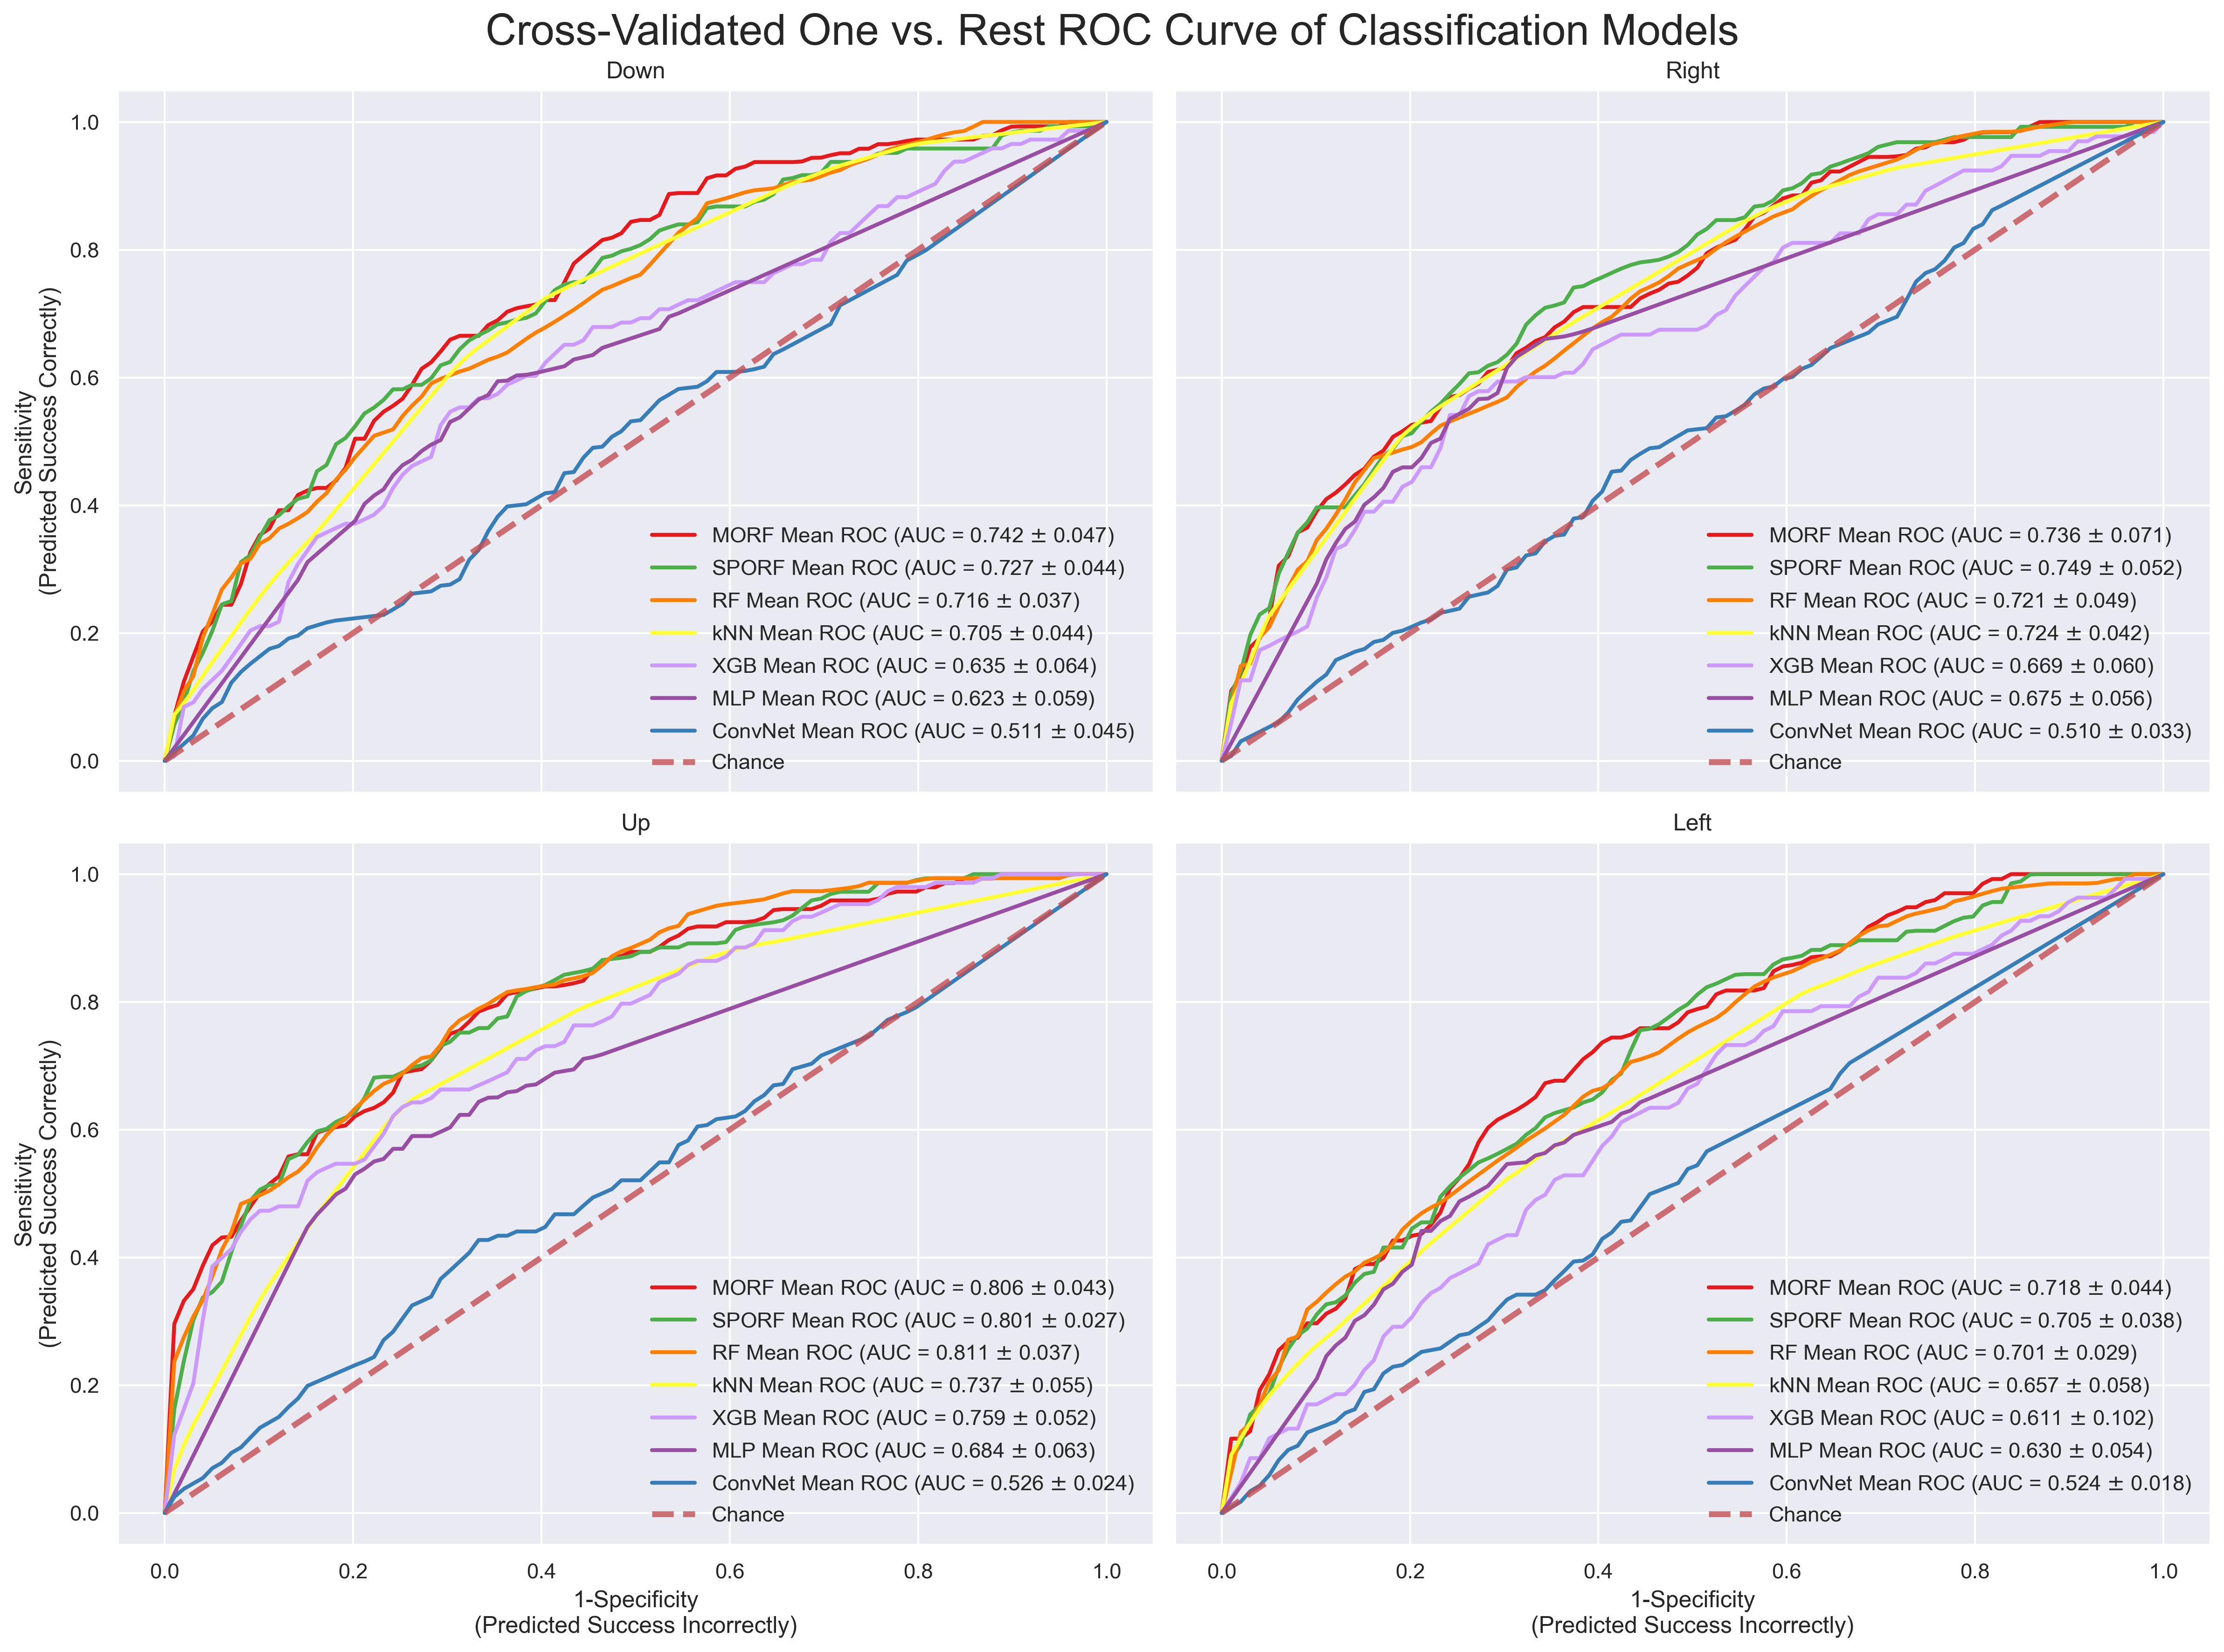

In [8]:
plot_multiclass_roc_comparison(cohort_clf_scores, show_chance=True)
plt.savefig("../figures/efri_directionality_decoding_roc_curves.png");